In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
import warnings
warnings.filterwarnings('ignore')
from collections import Counter



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/CPT_II_ConnersContinuousPerformanceTest.csv'
df = pd.read_csv(file_path, delimiter=';')
df.head()


,ID,Assessment Status,Assessment Duration,Type,LastTrial,Trial1,Response1,Trial2,Response2,Trial3,...,Raw Score HitRTIsi,Percent HitRTIsi,General TScore HitSEIsi,Adhd TScore HitSEIsi,Neuro TScore HitSEIsi,Raw Score HitSEIsi,Percent HitSEIsi,Adhd Confidence Index,Neuro Confidence Index,Old Overall Index
0,2,3,839999,6,360,11,-1,13,469,7,...,0.049592,0,48.021103,47.772537,43.224297,-0.021096,0,61.145496,58.749630,10.070000
1,3,3,839999,6,360,12,-1,0,371,2,...,0.064090,0,42.234097,38.263283,41.574574,-0.077351,0,86.871597,61.088688,4.440000
2,4,3,839999,6,360,14,-1,10,-1,3,...,0.077233,0,45.680782,42.289310,43.868061,-0.046142,0,99.900002,86.131813,18.340000
3,5,3,839999,6,360,12,459,7,289,12,...,0.085540,0,85.698700,70.469986,80.228539,0.410634,0,99.900002,99.900002,8.950001
4,7,3,839998,6,360,11,841,7,-1,5,...,0.024632,0,42.058998,43.349667,39.992119,-0.071200,0,32.291084,24.225414,0.000000


In [4]:
df.isna().sum()

,0
ID,0
Assessment Status,0
Assessment Duration,0
Type,0
LastTrial,0
...,...
Raw Score HitSEIsi,0
Percent HitSEIsi,0
Adhd Confidence Index,0
Neuro Confidence Index,0


In [5]:
df.isna().sum().sum()

np.int64(0)

In [6]:
# Define target variable (ADHD Confidence Index as binary classification)
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)  # 1 = ADHD, 0 = No ADHD



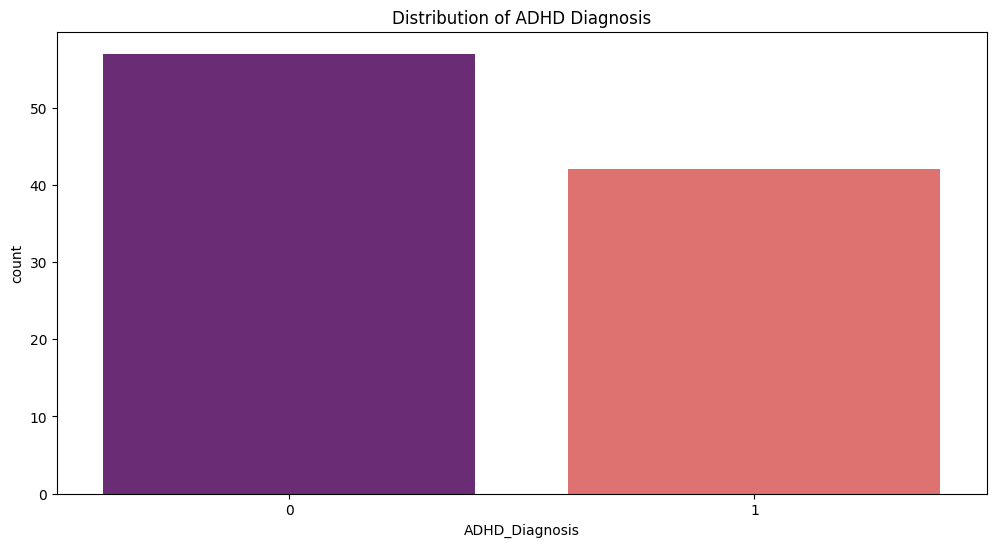

In [10]:
# Exploratory Data Analysis
plt.figure(figsize=(12,6))
sns.countplot(x='ADHD_Diagnosis', data=df, palette='magma')
plt.title('Distribution of ADHD Diagnosis')
plt.show()

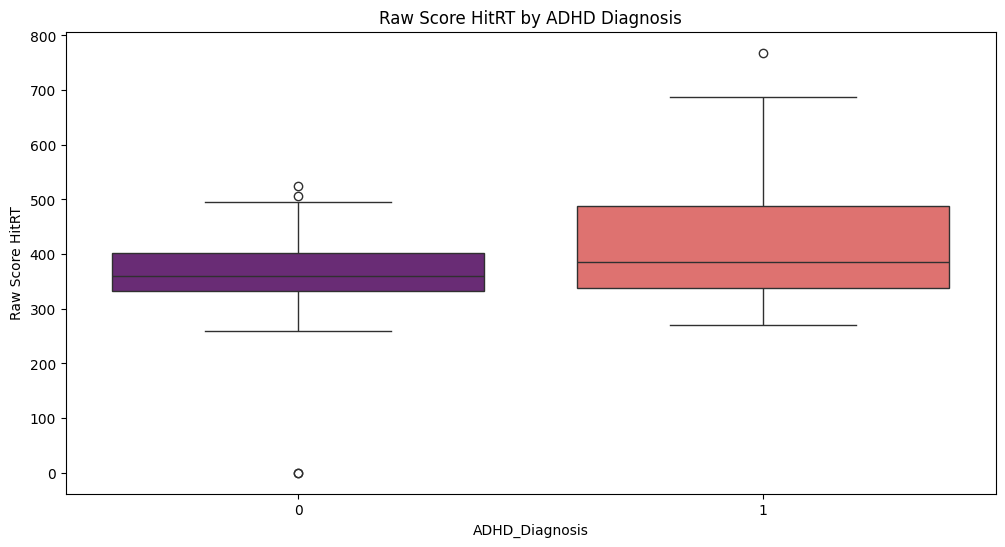

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='ADHD_Diagnosis', y=df['Raw Score HitRT'], data=df, palette='magma')
plt.title('Raw Score HitRT by ADHD Diagnosis')
plt.show()

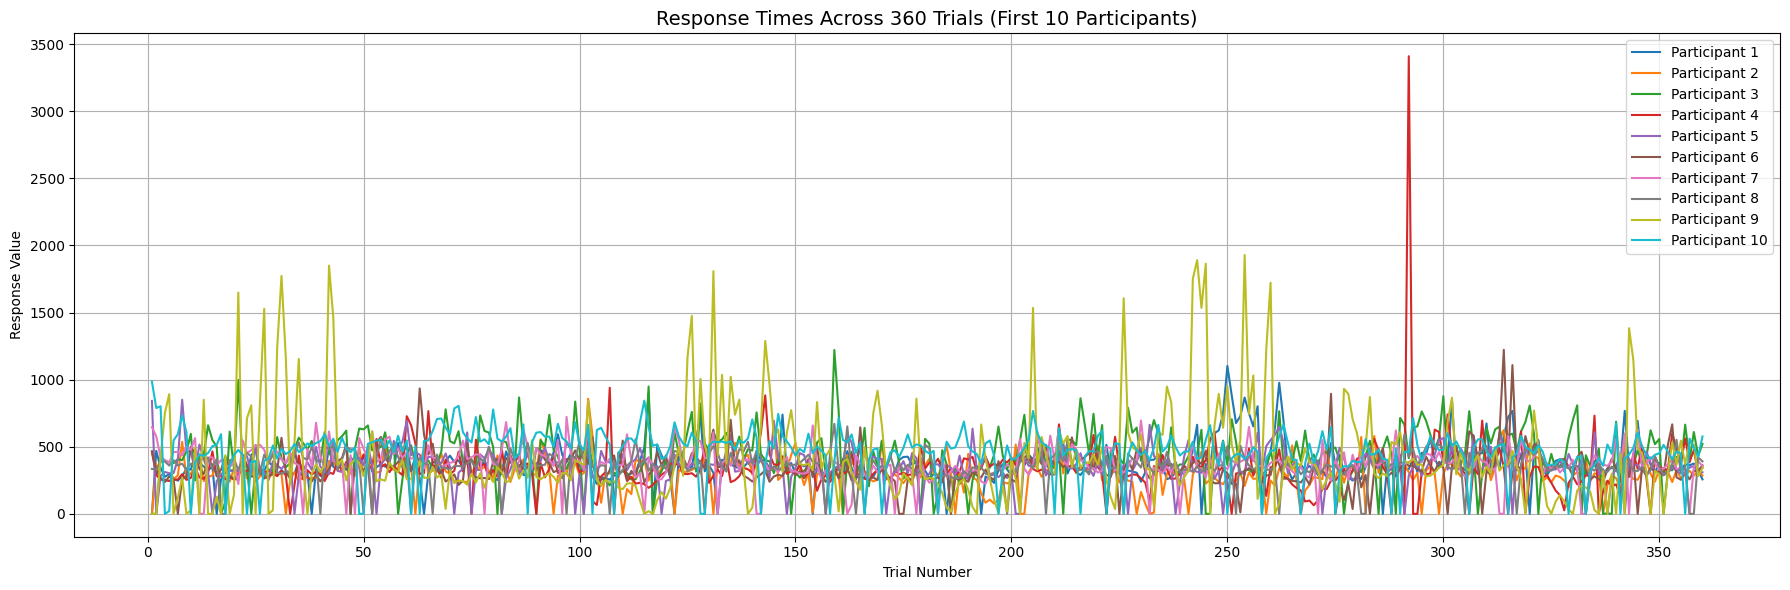

In [15]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Extract all Response columns (360 of them)
response_cols = [col for col in df.columns if 'Response' in col]

# Select a few participants (optional: to avoid overcrowding)
subset_df = df[response_cols].head(10)  # Plot for first 10 participants

# Plot the responses over trials
plt.figure(figsize=(18, 6))

for idx, row in subset_df.iterrows():
    plt.plot(range(1, len(response_cols) + 1), row.values, label=f'Participant {idx + 1}')

# Beautify the plot
plt.title('Response Times Across 360 Trials (First 10 Participants)', fontsize=14)
plt.xlabel('Trial Number')
plt.ylabel('Response Value')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

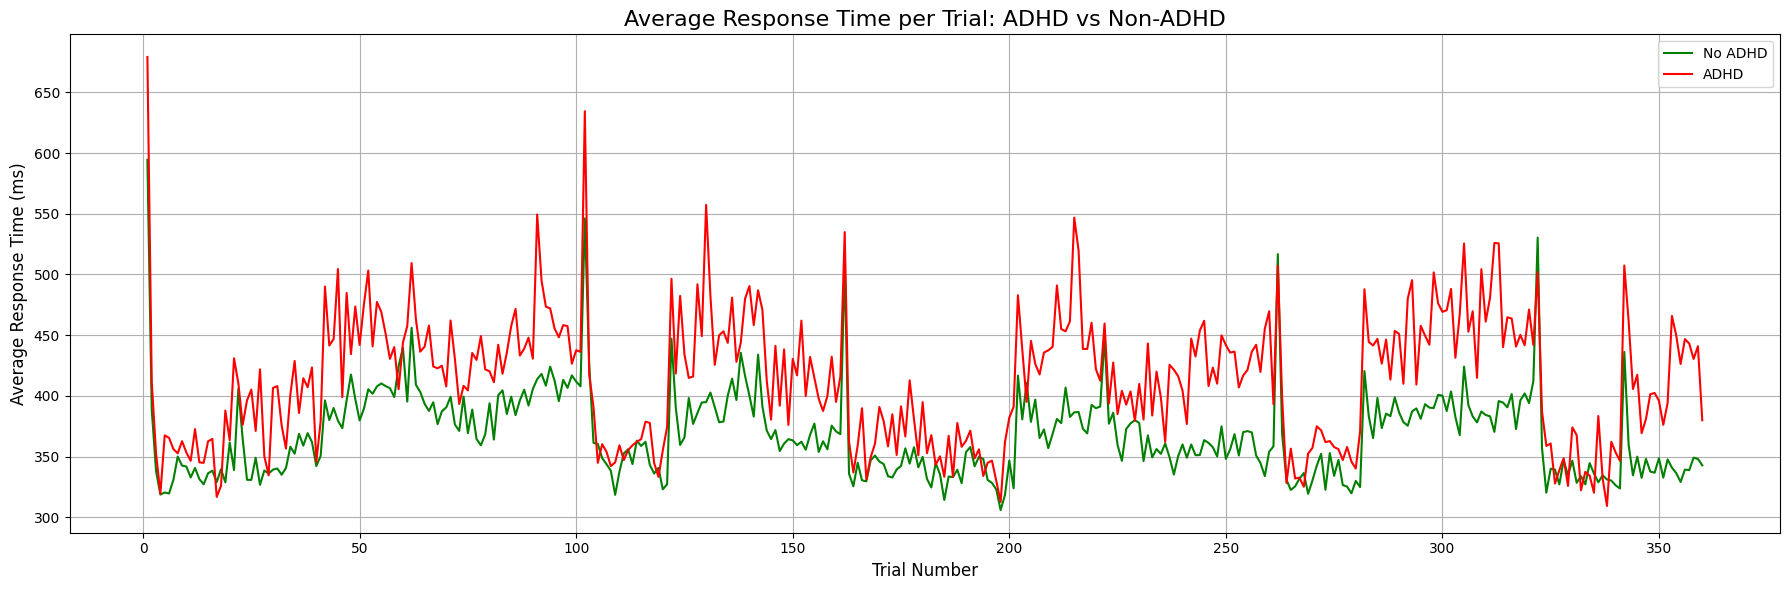

In [16]:
# Clean column names just in case there are extra spaces
df.columns = df.columns.str.strip()

# Create binary target column based on 'Adhd Confidence Index'
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)

# Get response columns
response_cols = [col for col in df.columns if 'Response' in col]

# Replace -1 with NaN for clean averaging
df[response_cols] = df[response_cols].replace(-1, np.nan)

# Calculate average response per trial for each group
adhd_group = df[df['ADHD_Diagnosis'] == 1][response_cols].mean()
non_adhd_group = df[df['ADHD_Diagnosis'] == 0][response_cols].mean()

# Plot
plt.figure(figsize=(18, 6))
plt.plot(range(1, 361), non_adhd_group.values, label='No ADHD', color='green')
plt.plot(range(1, 361), adhd_group.values, label='ADHD', color='red')

# Styling
plt.title('Average Response Time per Trial: ADHD vs Non-ADHD', fontsize=16)
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('Average Response Time (ms)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


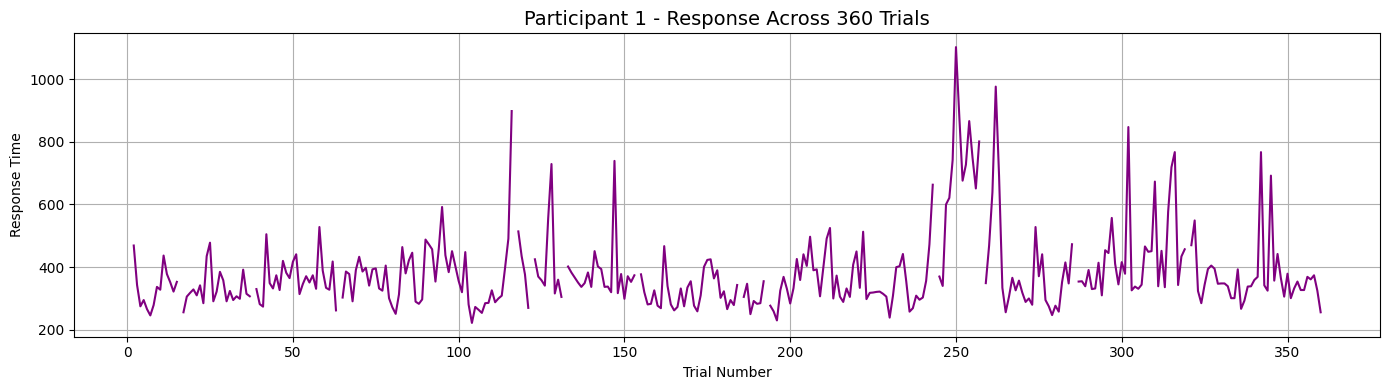

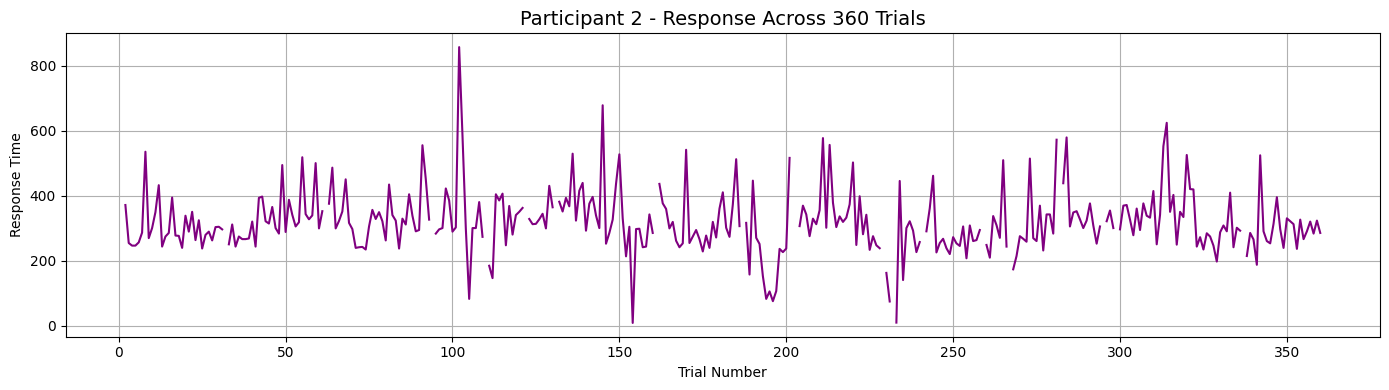

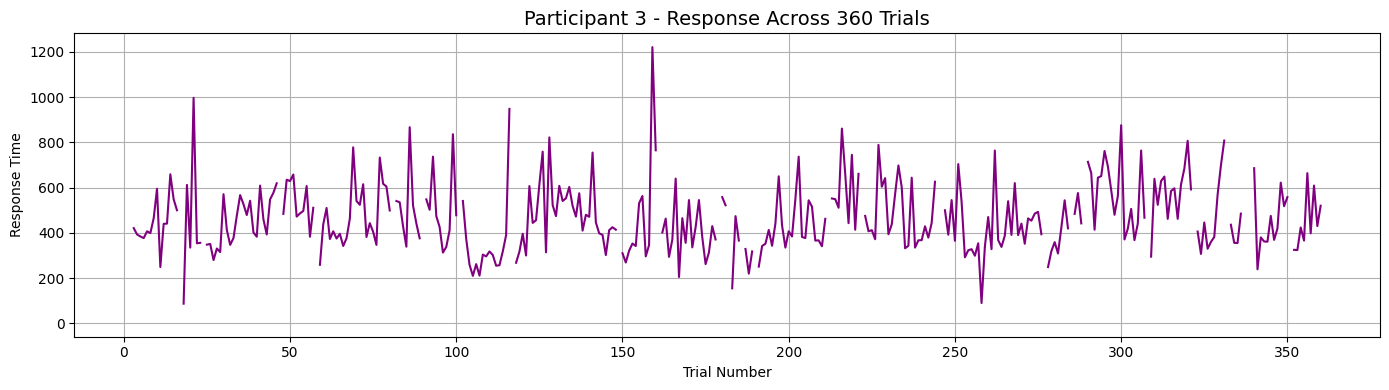

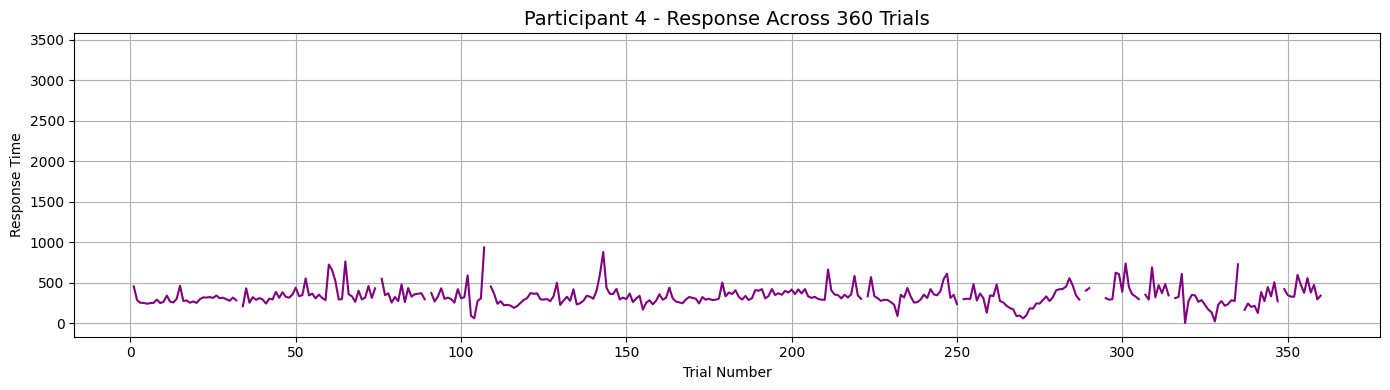

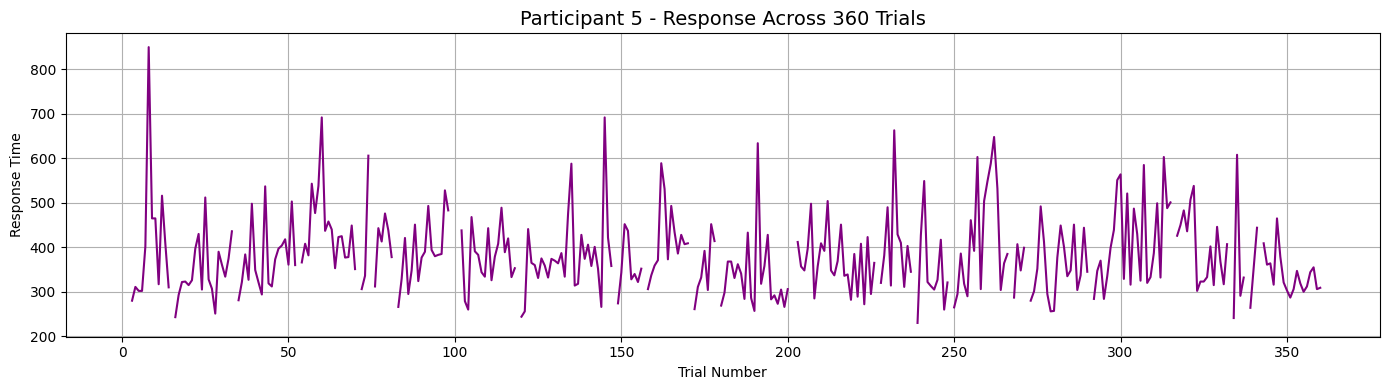

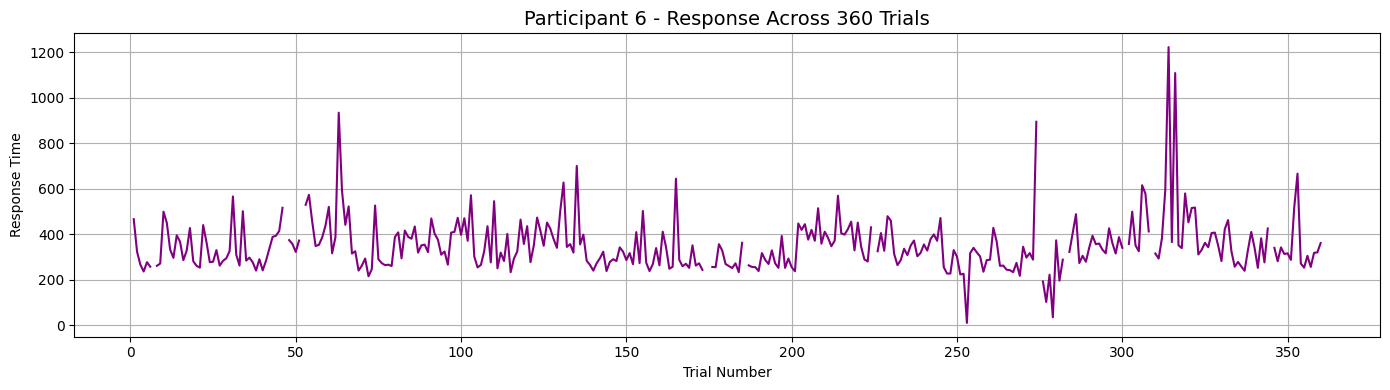

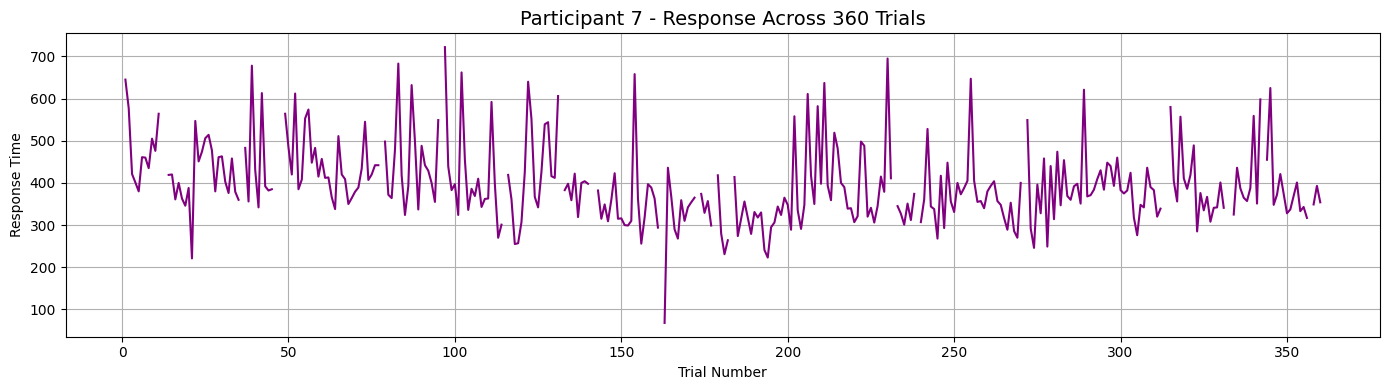

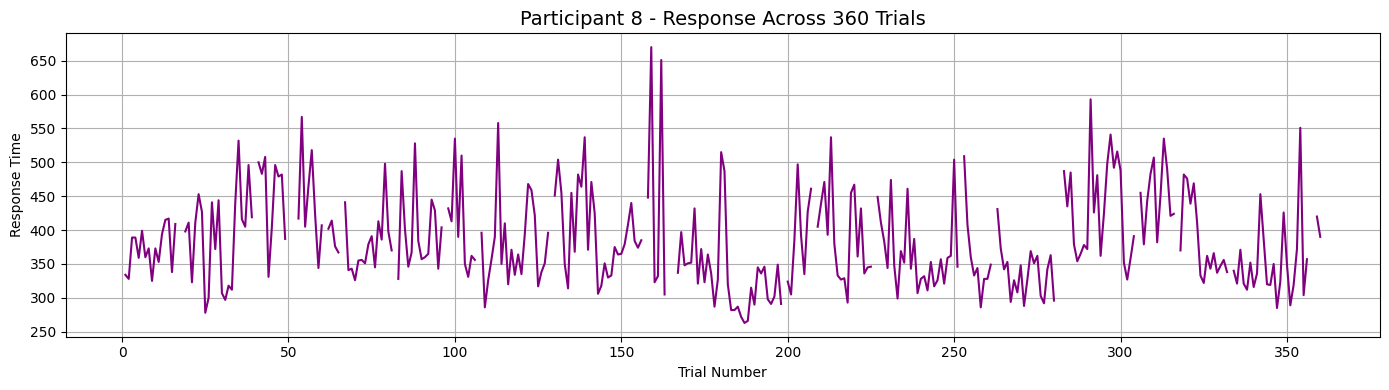

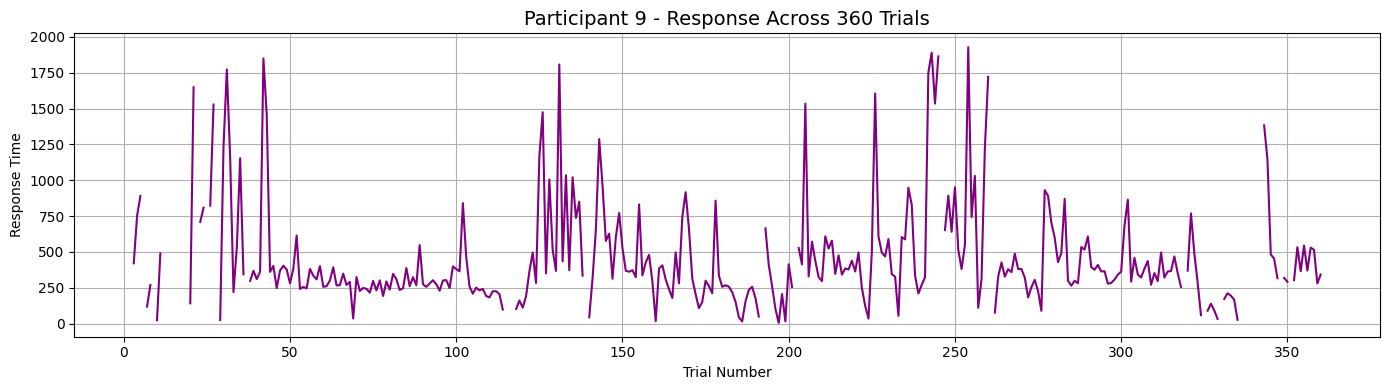

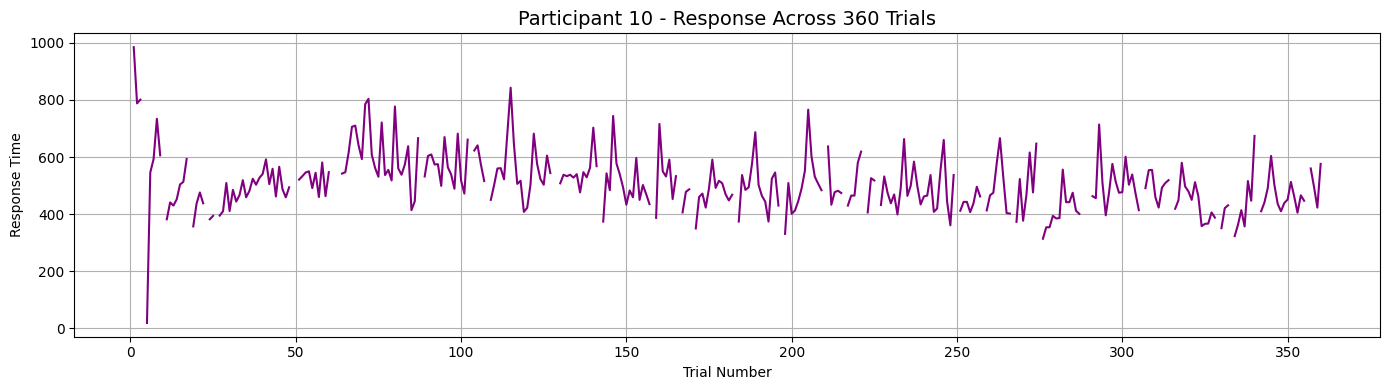

In [17]:
# Get all 360 response columns
response_cols = [col for col in df.columns if 'Response' in col]

# Loop over the first 10 participants
for i in range(10):
    plt.figure(figsize=(14, 4))
    plt.plot(range(1, 361), df.loc[i, response_cols].values, color='purple')
    plt.title(f'Participant {i+1} - Response Across 360 Trials', fontsize=14)
    plt.xlabel('Trial Number')
    plt.ylabel('Response Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


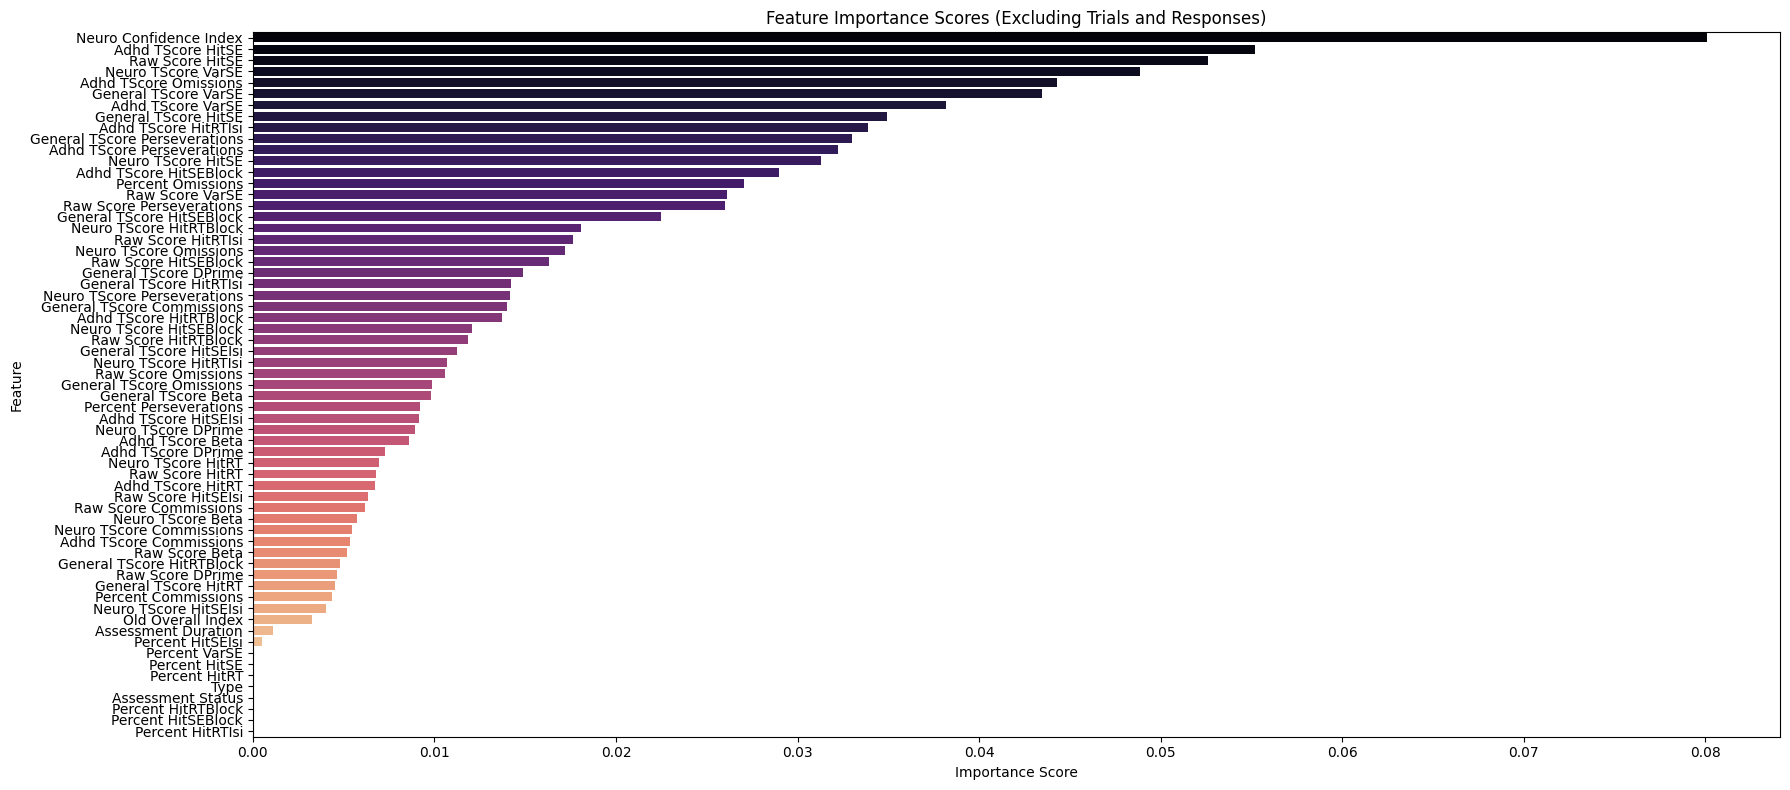

In [21]:
# Drop Trial and Response columns
columns_to_exclude = [col for col in df.columns if 'Trial' in col or 'Response'in col]

# Now drop non-relevant + Trial/Response columns
features_to_drop = ['ID', 'ADHD_Diagnosis', 'Adhd Confidence Index'] + columns_to_exclude
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']

# Feature Importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance':
rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot (Horizontal Bar Chart without Trial/Response columns)
plt.figure(figsize=(18, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='magma')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance Scores (Excluding Trials and Responses)")
plt.tight_layout()
plt.show()

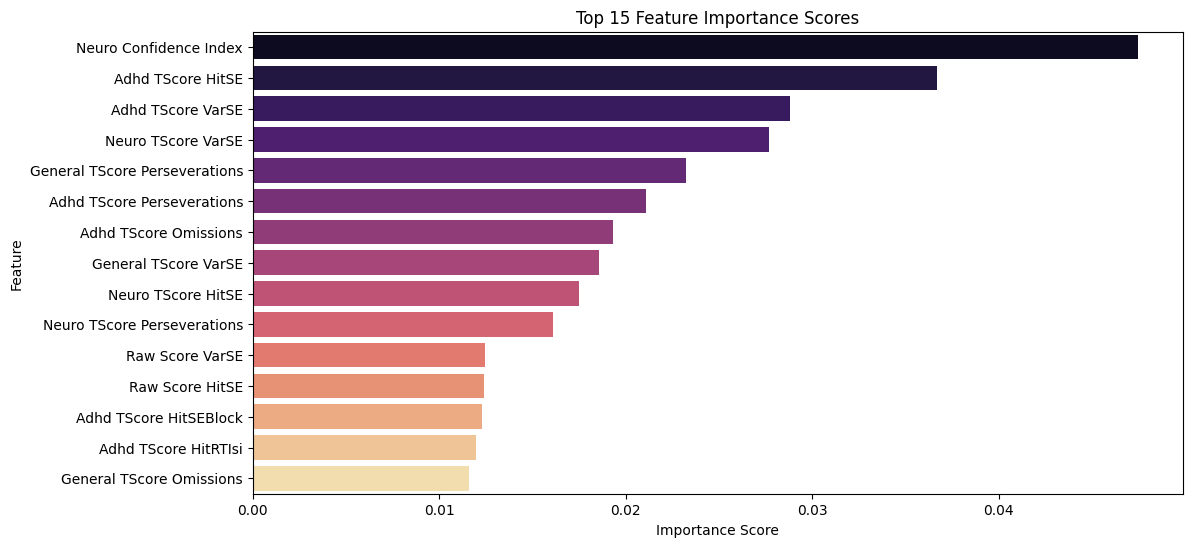

In [22]:
# Drop non-relevant columns (ID and categorical variables if any)
features_to_drop = ['ID', 'ADHD_Diagnosis', 'Adhd Confidence Index']
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']

# Feature Selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(15)
selected_features = feature_importances['Feature'].tolist()

# Keep only the top 15 most important features
X = X[selected_features]

# Plot Feature Importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='magma')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Feature Importance Scores")
plt.show()

In [23]:
selected_features

['Neuro Confidence Index',
 'Adhd TScore HitSE',
 'Adhd TScore VarSE',
 'Neuro TScore VarSE',
 'General TScore Perseverations',
 'Adhd TScore Perseverations',
 'Adhd TScore Omissions',
 'General TScore VarSE',
 'Neuro TScore HitSE',
 'Neuro TScore Perseverations',
 'Raw Score VarSE',
 'Raw Score HitSE',
 'Adhd TScore HitSEBlock',
 'Adhd TScore HitRTIsi',
 'General TScore Omissions']

In [24]:
df_combined = pd.concat([X, y], axis=1)
df_combined.head()

,Neuro Confidence Index,Adhd TScore HitSE,Adhd TScore VarSE,Neuro TScore VarSE,General TScore Perseverations,Adhd TScore Perseverations,Adhd TScore Omissions,General TScore VarSE,Neuro TScore HitSE,Neuro TScore Perseverations,Raw Score VarSE,Raw Score HitSE,Adhd TScore HitSEBlock,Adhd TScore HitRTIsi,General TScore Omissions,ADHD_Diagnosis
0,58.749630,52.266724,56.680264,47.313202,45.910095,45.960991,48.617069,63.262173,46.328171,44.977715,11.213081,7.099574,73.413300,44.764221,61.888031,1
1,61.088688,49.884254,52.487644,44.698776,151.525207,77.101982,70.258568,55.966831,43.217041,49.628159,7.517670,5.512853,56.108963,53.880283,78.756966,1
2,86.131813,73.548889,51.577404,44.092140,109.223038,64.040787,81.135651,54.914539,50.403320,48.388687,7.212327,8.852735,53.179558,57.213779,92.086784,1
3,99.900002,57.789284,67.443703,71.502686,95.529411,60.982868,50.876575,83.324196,56.714081,64.221878,43.372417,11.575007,72.043434,51.601707,70.983177,1
4,24.225414,43.678928,42.459812,39.814167,45.910095,45.960991,45.635860,47.997269,40.733135,44.977715,5.363655,5.002260,49.865376,38.070797,46.636135,0


In [25]:
df=df_combined.copy()

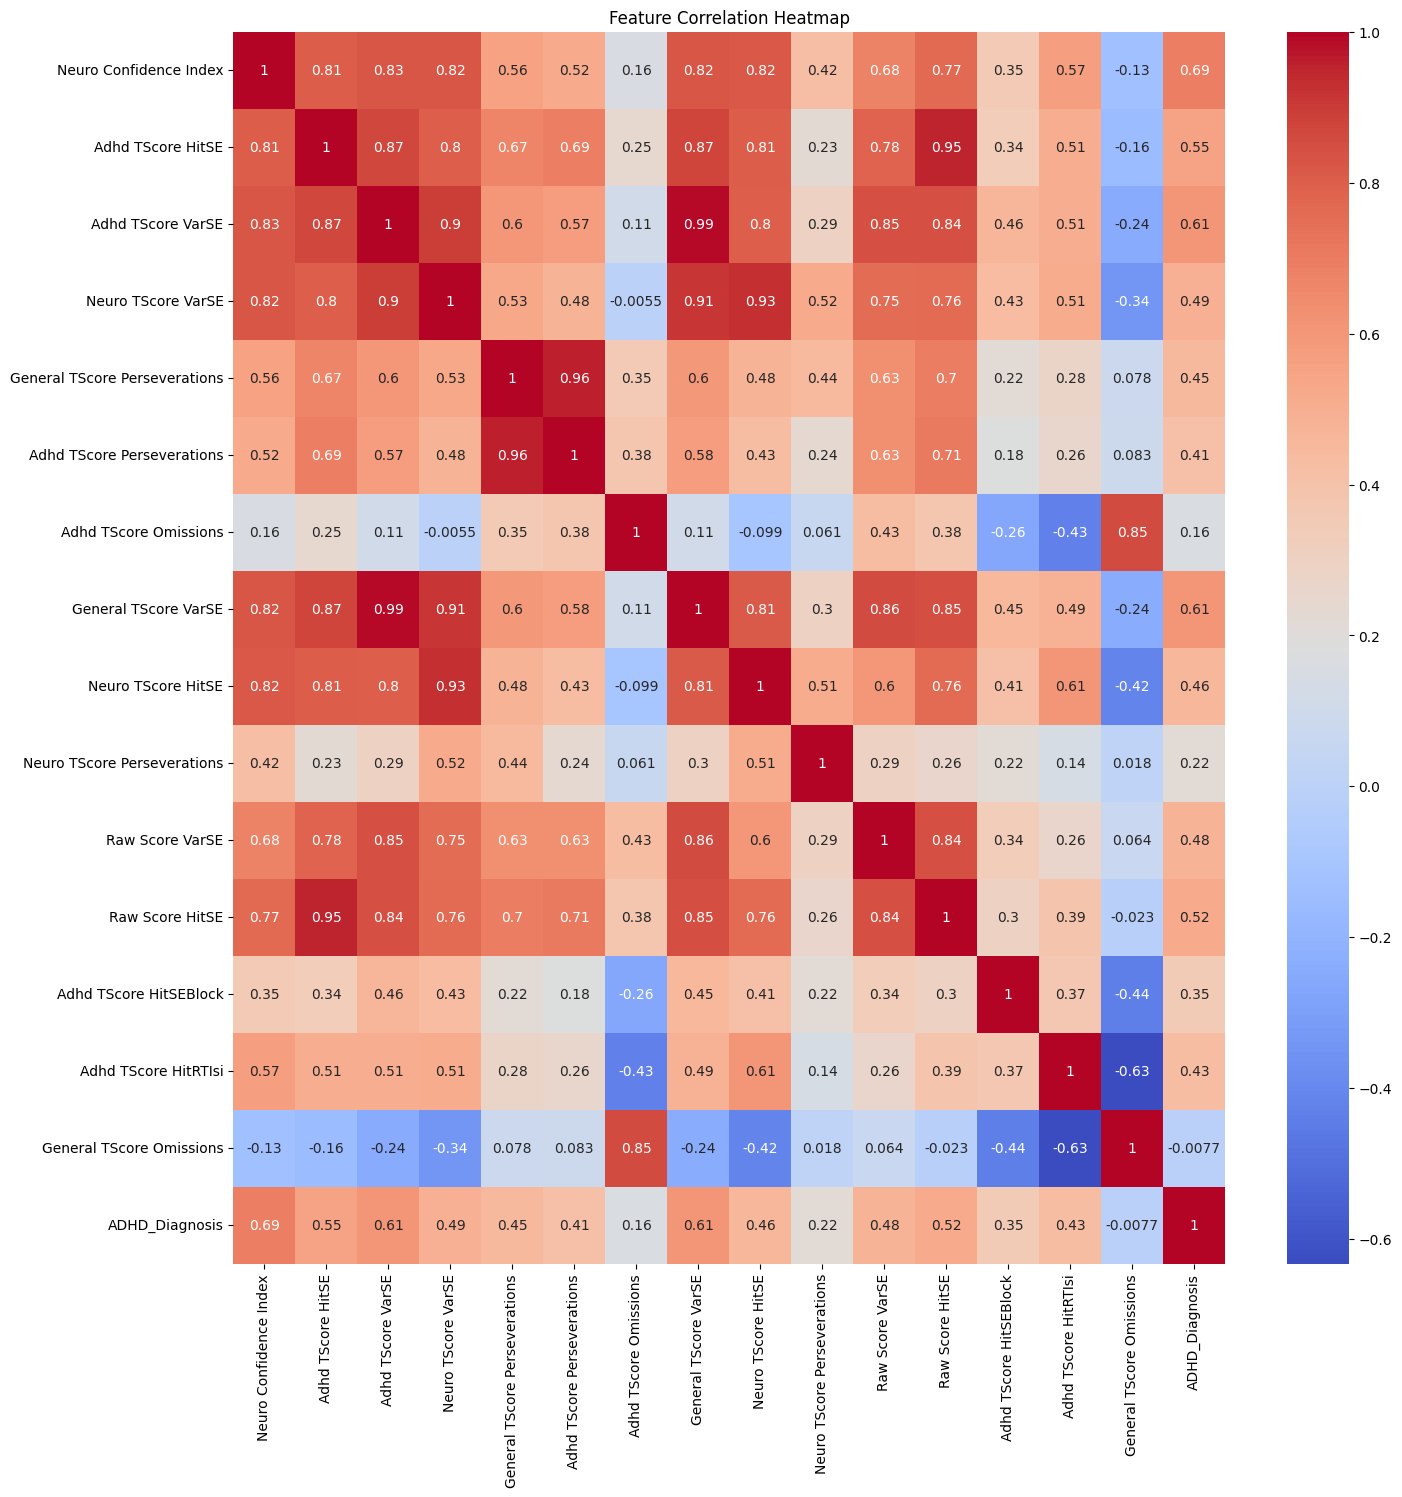

In [26]:
# Feature Correlation Heatmap
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
# Drop non-relevant columns (ID and categorical variables if any)
features_to_drop = ['ID', 'Adhd Confidence Index', 'ADHD_Diagnosis']
X = df.drop(columns=features_to_drop, errors='ignore')
y = df['ADHD_Diagnosis']


# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
def plot_misclassification_frequency(y_true, y_pred, model_name):
    incorrect_mask = y_true != y_pred
    incorrect_labels = y_true[incorrect_mask]
    predicted_labels = y_pred[incorrect_mask]

    misclassified = [f"Actual {a} → Pred {p}" for a, p in zip(incorrect_labels, predicted_labels)]
    count = Counter(misclassified)
    freq_df = pd.DataFrame(count.items(), columns=["Misclassification Type", "Frequency"])
    freq_df.sort_values("Frequency", ascending=False, inplace=True)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=freq_df, x="Misclassification Type", y="Frequency", palette="pastel")
    plt.title(f"Frequency of Misclassifications: {model_name}", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()


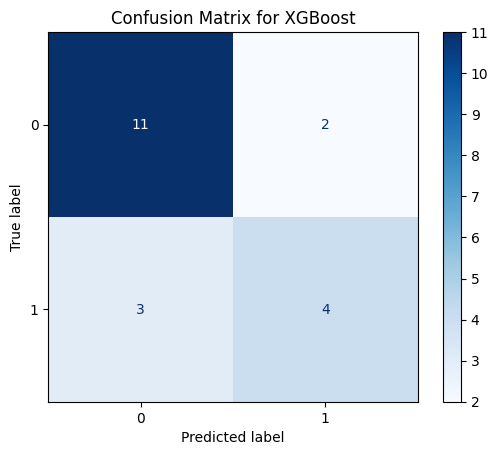

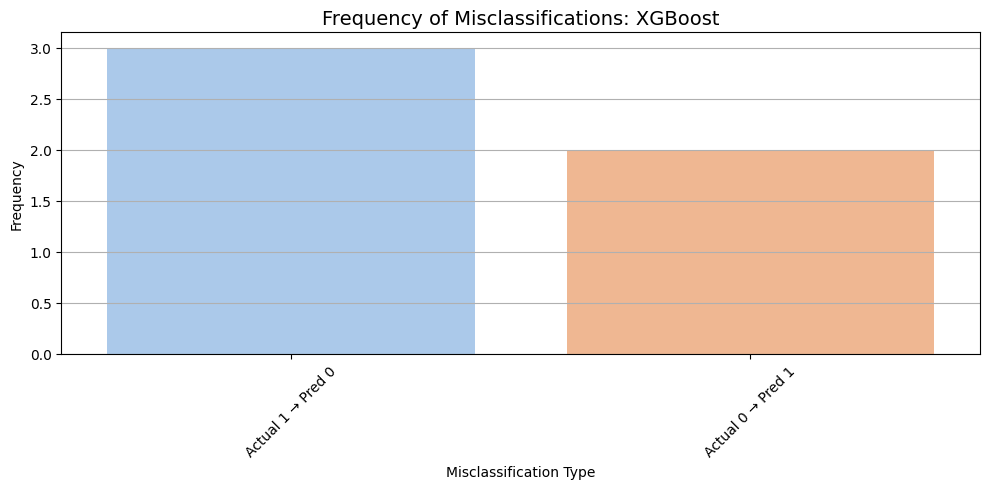


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.67      0.57      0.62         7

    accuracy                           0.75        20
   macro avg       0.73      0.71      0.72        20
weighted avg       0.74      0.75      0.75        20

[LightGBM] [Info] Number of positive: 35, number of negative: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443038 -> initscore=-0.228842
[LightGBM] [Info] Start training from score -0.228842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

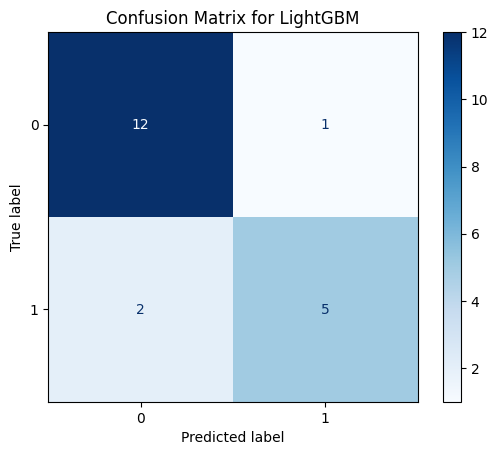

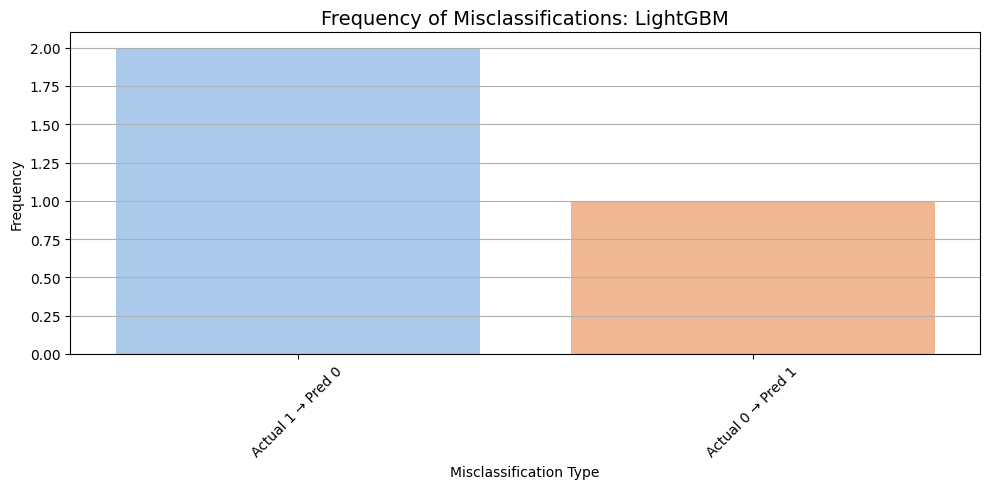


Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.83      0.71      0.77         7

    accuracy                           0.85        20
   macro avg       0.85      0.82      0.83        20
weighted avg       0.85      0.85      0.85        20



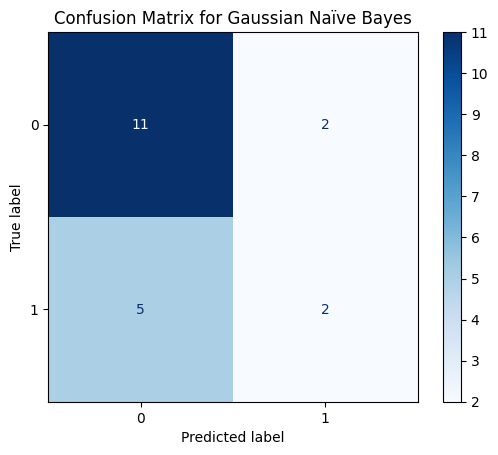

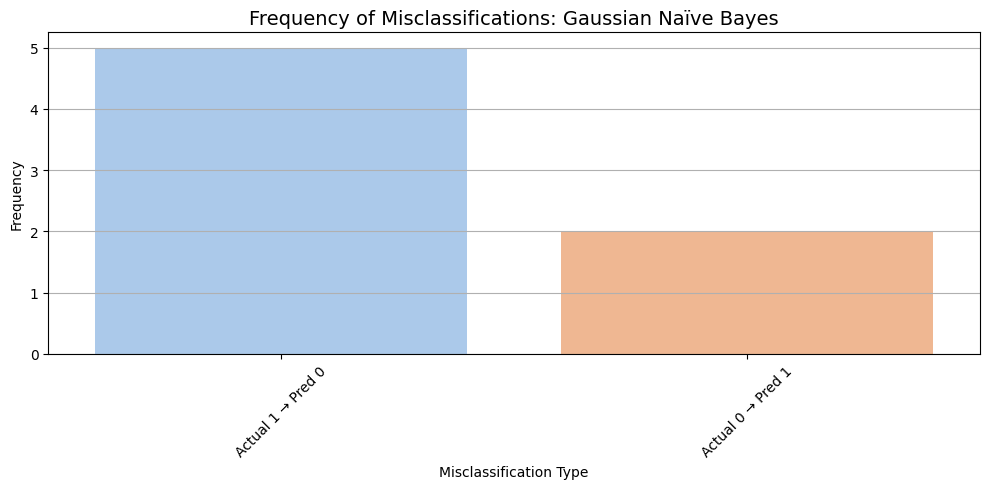


Classification Report for Gaussian Naïve Bayes:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.50      0.29      0.36         7

    accuracy                           0.65        20
   macro avg       0.59      0.57      0.56        20
weighted avg       0.62      0.65      0.62        20

                  Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0               XGBoost      0.75   0.666667  0.571429  0.615385  0.912088
1              LightGBM      0.85   0.833333  0.714286  0.769231  0.879121
2  Gaussian Naïve Bayes      0.65   0.500000  0.285714  0.363636  0.813187


In [ ]:
# Initialize models
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "Gaussian Naïve Bayes": GaussianNB()
}

# Train and evaluate models
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Confusion matrix and misclassification plot
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    plot_misclassification_frequency(y_test, y_pred, model_name)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })


# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.4636 - loss: 0.7030 - val_accuracy: 0.7500 - val_loss: 0.5941
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8631 - loss: 0.5879 - val_accuracy: 0.7500 - val_loss: 0.5220
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8633 - loss: 0.5084 - val_accuracy: 0.7500 - val_loss: 0.4776
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8945 - loss: 0.4671 - val_accuracy: 0.7500 - val_loss: 0.4481
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8424 - loss: 0.4276 - val_accuracy: 0.7500 - val_loss: 0.4261
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8525 - loss: 0.3885 - val_accuracy: 0.7500 - val_loss: 0.4066
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8633 - loss: 0.3863 - val_accuracy: 0.7500 - val_loss: 0.3910
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8527 - loss: 0.3791 - val_accuracy: 0.7500 - val_loss: 0.3

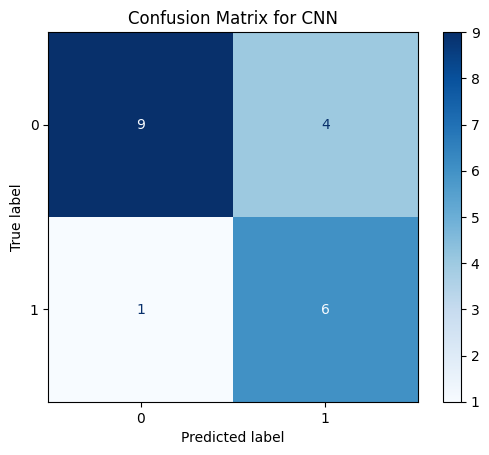

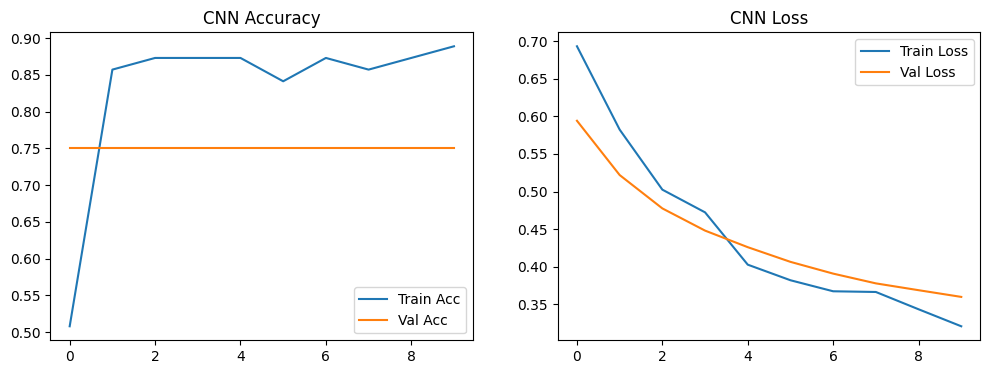

In [ ]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# CNN Evaluation
cnn_preds = (cnn_model.predict(X_test.reshape(-1, X_test.shape[1], 1)) > 0.5).astype(int)
print("\nCNN Classification Report:")
print(classification_report(y_test, cnn_preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, cnn_preds)).plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.show()

# CNN Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Acc')
plt.plot(cnn_history.history['val_accuracy'], label='Val Acc')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

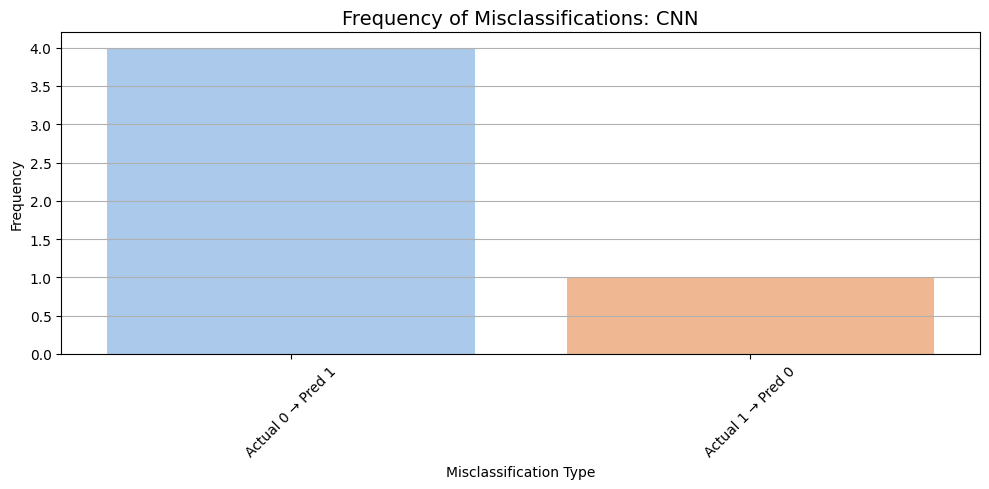

In [ ]:
plot_misclassification_frequency(y_test, cnn_preds.flatten(), "CNN")


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.5574 - loss: 0.6911 - val_accuracy: 0.8750 - val_loss: 0.6546
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6319 - loss: 0.6685 - val_accuracy: 0.8750 - val_loss: 0.6317
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8419 - loss: 0.6439 - val_accuracy: 0.8750 - val_loss: 0.6102
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8317 - loss: 0.6364 - val_accuracy: 0.8750 - val_loss: 0.5864
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8421 - loss: 0.5932 - val_accuracy: 0.8750 - val_loss: 0.5603
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8841 - loss: 0.5797 - val_accuracy: 0.8125 - val_loss: 0.5335
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7688 - loss: 0.5698 - val_accuracy: 0.8125 - val_loss: 0.5058
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8525 - loss: 0.5147 - val_accuracy: 0.8125 - val_loss: 0.4

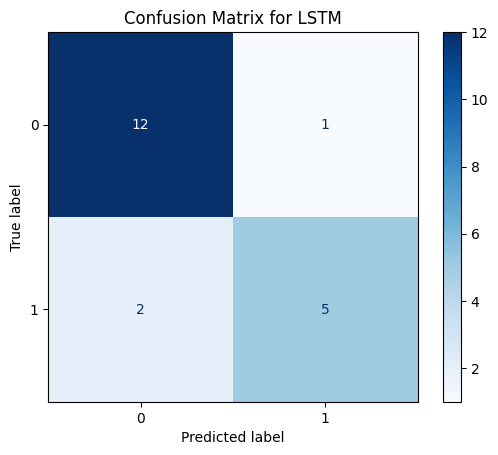

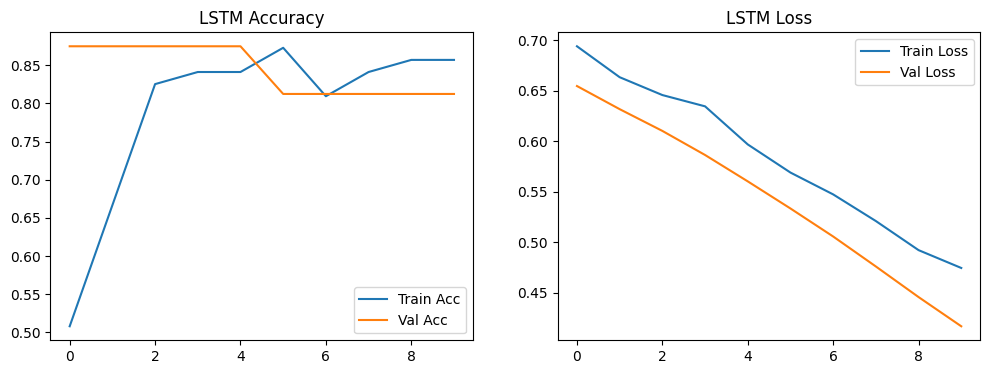

In [ ]:
# LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# LSTM Evaluation
lstm_preds = (lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1)) > 0.5).astype(int)
print("\nLSTM Classification Report:")
print(classification_report(y_test, lstm_preds))
ConfusionMatrixDisplay(confusion_matrix(y_test, lstm_preds)).plot(cmap='Blues')
plt.title("Confusion Matrix for LSTM")
plt.show()

# LSTM Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss')
plt.legend()
plt.show()


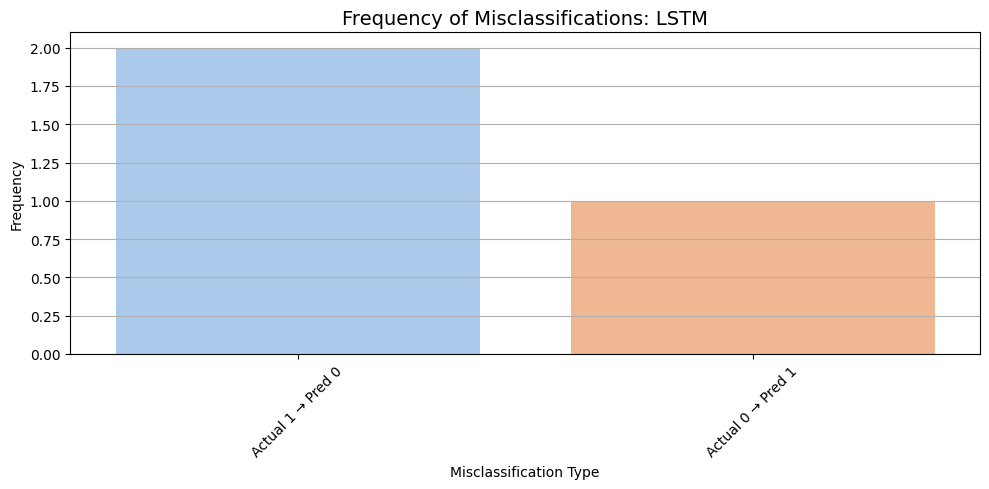

In [ ]:
plot_misclassification_frequency(y_test, lstm_preds.flatten(), "LSTM")


In [27]:
# Reuse your full dataset from previous block
file_path = '/content/drive/MyDrive/CPT_II_ConnersContinuousPerformanceTest.csv'
df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip()
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)

# Drop ID and irrelevant columns
X_full = df.drop(columns=['ID', 'Adhd Confidence Index', 'ADHD_Diagnosis'], errors='ignore')
y = df['ADHD_Diagnosis']

# Fill missing values
X_full.replace(-1, np.nan, inplace=True)
X_full.fillna(X_full.median(numeric_only=True), inplace=True)

# Encode categorical columns
for col in X_full.select_dtypes(include='object').columns:
    X_full[col] = LabelEncoder().fit_transform(X_full[col])

# Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_full, y)
feature_importance = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 15 features
top_15_features = feature_importance.head(15)['Feature'].tolist()
X_top15 = X_full[top_15_features]

# Scale both full and top 15 datasets
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_full)
X_top15_scaled = scaler.fit_transform(X_top15)

# Train-test split
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all_scaled, y, test_size=0.2, random_state=42)
X_top_train, X_top_test = train_test_split(X_top15_scaled, test_size=0.2, random_state=42)

# Define models again
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "GaussianNB": GaussianNB()
}

# Function to train and evaluate
def evaluate_models(X_train, X_test, y_train, y_test, label):
    print(f"\n=== Results using {label} ===")
    result_data = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        result_data.append({
            "Model": name,
            "Feature Set": label,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob)
        })

        print(f"\n{name} Classification Report ({label}):\n")
        print(classification_report(y_test, y_pred))

    return result_data

# Evaluate on both datasets
results_all = evaluate_models(X_all_train, X_all_test, y_train, y_test, 'All Features')
results_top15 = evaluate_models(X_top_train, X_top_test, y_train, y_test, 'Top 15 Features')

# Combine and compare results
combined_results = pd.DataFrame(results_all + results_top15)
print("\nComparison of All Features vs Top 15:\n")
print(combined_results)


=== Results using All Features ===

XGBoost Classification Report (All Features):

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.57      0.57      0.57         7

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20

[LightGBM] [Info] Number of positive: 35, number of negative: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15853
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443038 -> initscore=-0.228842
[LightGBM] [Info] Start training from score -0.228842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

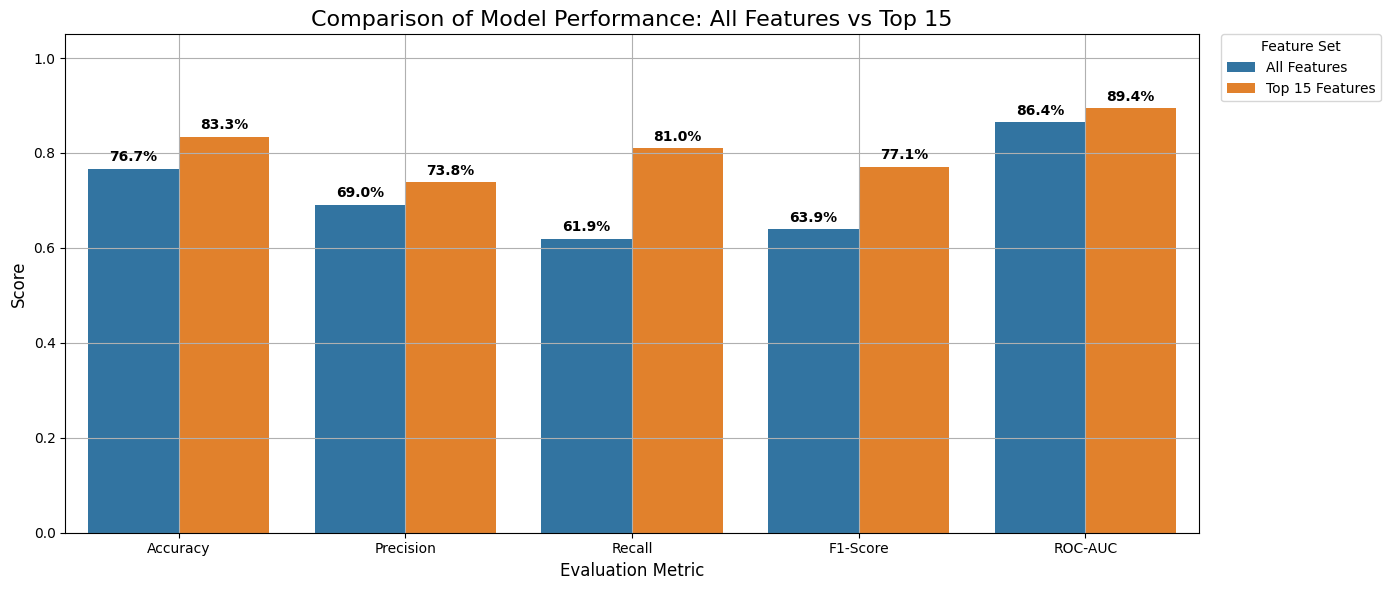

In [28]:
# Set visual style
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the result dataframe for seaborn
melted = combined_results.melt(id_vars=["Model", "Feature Set"],
                               value_vars=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
                               var_name="Metric",
                               value_name="Score")

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Feature Set", ci=None)

# Add score labels on top of each bar, only if height > 0
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add text if bar has non-zero height
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f'{height * 100:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.title("Comparison of Model Performance: All Features vs Top 15", fontsize=16)
plt.xlabel("Evaluation Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)

# Move legend outside
plt.legend(title="Feature Set", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()